In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
import os
from wrangle import acquire_zillow, handle_missing_values, prep_zillow, handle_outliers
import re
import PyPDF2
import explore

In [4]:
db = acquire_zillow()
db = db.rename(columns = {'max(logerror)' : 'error'})
db = handle_missing_values(db)
db = prep_zillow(db)

In [5]:
pd.set_option('max_columns', None)

In [24]:
db.groupby("propertylandusedesc").count()

,parcelid,propertylandusetypeid,heatingorsystemtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,county,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,error,transactiondate,heatingorsystemdesc
propertylandusedesc,,,,,,,,,,,,,,,,,,,,,,,,,,
"Manufactured, Modular, Prefabricated Homes",34,34,0,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
Mobile Home,59,59,0,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
Single Family Residential,51850,51850,33599,51850,51850,51850,51835,51850,51850,51850,51850,51850,51850,51850,51850,51850,51850,51822,51788,51850,51850,51846,51764,51850,51850,51850


In [7]:
db = db[(db['regionidzip'] < 100000)]

In [8]:
db.head()

,parcelid,propertylandusetypeid,heatingorsystemtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,county,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,error,transactiondate,heatingorsystemdesc,propertylandusedesc
0,10711855,261.0,2.0,2.0,3.0,8.0,2.0,2107.0,Los Angeles,34222559.0,-118617387.0,9158.0,6.037113e+07,3101.0,96339.0,0.0,1.0,1972.0,249655.0,624139.0,374484.0,7659.36,6.037113e+13,-0.007357,2017-07-07,Central,Single Family Residential
1,10711877,261.0,2.0,2.0,4.0,8.0,2.0,1882.0,Los Angeles,34220261.0,-118616409.0,9035.0,6.037113e+07,3101.0,96339.0,0.0,1.0,1972.0,253000.0,660000.0,407000.0,8123.91,6.037113e+13,0.021066,2017-08-29,Central,Single Family Residential
2,10711888,261.0,2.0,2.0,4.0,8.0,2.0,1882.0,Los Angeles,34222491.0,-118616854.0,9800.0,6.037113e+07,3101.0,96339.0,0.0,1.0,1972.0,257591.0,542923.0,285332.0,6673.24,6.037113e+13,0.077174,2017-04-04,Central,Single Family Residential
3,10711910,261.0,2.0,2.0,3.0,8.0,2.0,1477.0,Los Angeles,34221864.0,-118615739.0,11285.0,6.037113e+07,3101.0,96339.0,0.0,1.0,1960.0,57968.0,78031.0,20063.0,1116.46,6.037113e+13,-0.041238,2017-03-17,Central,Single Family Residential
4,10711923,261.0,2.0,2.0,4.0,8.0,2.0,1918.0,Los Angeles,34220619.0,-118615253.0,11239.0,6.037113e+07,3101.0,96339.0,0.0,1.0,1960.0,167869.0,415459.0,247590.0,5239.85,6.037113e+13,-0.009496,2017-03-24,Central,Single Family Residential


In [9]:
train, test = train_test_split(db, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [10]:
binary_vars = []
categorical_vars = ['county', 'propertylandusetypeid']
quant_vars = ['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt']
categorical_target = 'error_class'
continuous_target = 'error'

<AxesSubplot:xlabel='county', ylabel='error'>

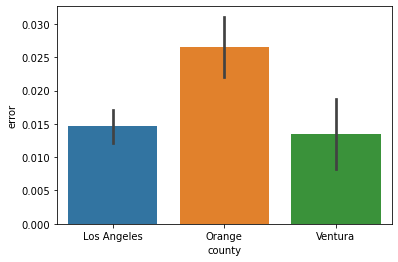

In [11]:
sns.barplot(x = train['county'], y = train['error'])

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='error', ylabel='Count'>

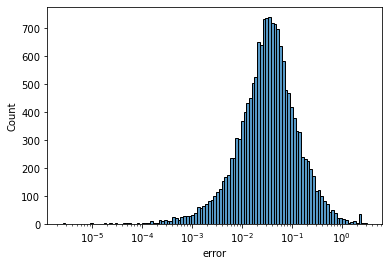

In [12]:
sns.histplot(train['error'], log_scale = True)

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='error'>

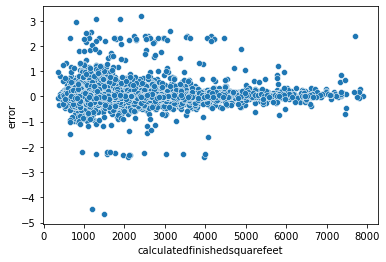

In [13]:
sns.scatterplot(x = train['calculatedfinishedsquarefeet'], y = train['error'])

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='error'>

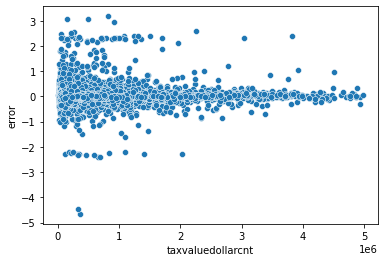

In [14]:
sns.scatterplot(x = train['taxvaluedollarcnt'], y = train['error'])

<AxesSubplot:xlabel='yearbuilt', ylabel='error'>

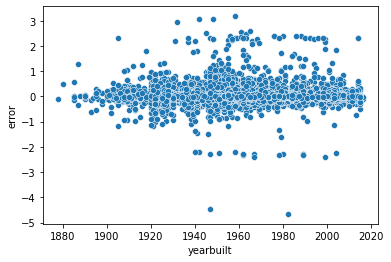

In [15]:
sns.scatterplot(x = train['yearbuilt'], y = train['error'])

<AxesSubplot:xlabel='propertylandusetypeid', ylabel='error'>

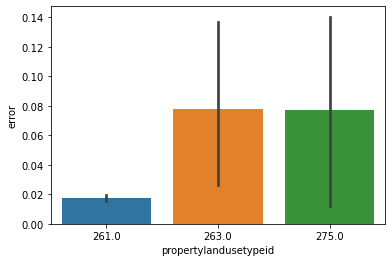

In [16]:
sns.barplot(x = train['propertylandusetypeid'], y = train['error'])

## Test 1

Is logerror significantly different for properties in LA County vs. Orange County?

In [17]:
x1 = train[train['county'] == 'Los Angeles']
x2 = train[train['county'] == 'Orange']
stats.ttest_ind(x1['error'], x2['error'])

Ttest_indResult(statistic=-4.922503933768536, pvalue=8.595459414063967e-07)

This is indicative that there may be a significant difference in logerror between Los Angeles and Orange County

## Test 2

Now let's do the same for LA County and Ventura County

In [18]:
x1 = train[train['county'] == 'Los Angeles']
x2 = train[train['county'] == 'Ventura']
stats.ttest_ind(x1['error'], x2['error'])

Ttest_indResult(statistic=0.3577964883356299, pvalue=0.7204991685305175)

This shows that there is likely not a significant difference in logerror between LA and Ventura counties

## Test 3

Ventura and Orange counties

In [19]:
x1 = train[train['county'] == 'Orange']
x2 = train[train['county'] == 'Ventura']
stats.ttest_ind(x1['error'], x2['error'])

Ttest_indResult(statistic=2.9780125117961, pvalue=0.002908010818608747)

It would seem Orange County has a significant difference in logerror between LA and Ventura.

## Test 4

Is there a correlation between square footage and logerror?

In [20]:
corr, p = stats.pearsonr(train['calculatedfinishedsquarefeet'], train['error'])
corr, p

(0.04085911881753078, 3.1447694150199207e-12)

No significant correlation can be seen between square footage and logerror

## Test 5

Is there a significant difference in logerror for mobile homes compared to the average?

In [21]:
x1 = train[train['propertylandusetypeid'] == 263]
x1 = x1['error']
x2 = train.error.mean()
t, p = stats.ttest_1samp(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 2.113
p = 0.042


This suggests that there is a significant difference in the logerror of estimating mobile homes

## Gathering zipcodes from specified counties

In [ ]:
def get_full_text(file):
    pdfReader = PyPDF2.PdfFileReader(file)
    pages = pdfReader.numPages
    fulltext = ''
    for i in range(0, pages):
        page = pdfReader.getPage(i)
        page = page.extractText()
        fulltext = fulltext + page
    return fulltext

In [ ]:
book_la = get_full_text('LaZips.pdf')

In [ ]:
book_la = get_full_text('LaZips.pdf')
zip_list_la = re.findall(r"\D(\d{5})\D", book_la)
book_o = get_full_text('OrangeCountyZips.pdf')
zip_list_o = re.findall(r"\D(\d{5})\D", book_o)
zip_list_o.pop()
book_v = get_full_text('VenturaZips.pdf')
zip_list_v = re.findall(r"\D(\d{5})\D", book_v)
all_zips = zip_list_la + zip_list_o + zip_list_v
g = [int(i) for i in all_zips]
db = db.astype({'regionidzip': 'int'})
fixed = db[db.regionidzip.isin(g)]

In [ ]:
fixed

After getting zipcodes from the counties from various sources, I have discovered that the zipcode list is not reliable, as none of the zipcodes listed are in the counties of Orange, Los Angeles, or Ventura.